# Quantum Convolutional Neural Network (QCNN)
## [CSC8851] Deep Learning Project - 2024 Submission
### Author: Raja Appapurapu  
**PhD Student, Georgia State University**  
**Email:** [rappapurapu1@student.gsu.edu](mailto:rappapurapu1@student.gsu.edu)

---

## Project Overview

This project implements a **Quantum Convolutional Neural Network (QCNN)** using PyTorch. The goal is to mimic the behavior of a QCNN with:
- **Modified Training**: Quantum Backpropagation.
- **Modified Forward Pass**: Incorporating probabilistic sampling and error introduction.

## Key Features:
- **Quantum-Inspired Learning**: The CNN is enhanced with quantum-inspired techniques such as quantum backpropagation and quantum noise injection.
- **Probabilistic Sampling**: Forward passes include quantum sampling mechanisms to introduce a probabilistic element.
- **Error Introduction**: Noise and perturbation functions are applied to simulate quantum uncertainty in data processing.
  
---

## Code Details:
- **Framework**: PyTorch
- **Primary Objective**: Explore quantum-inspired neural network architectures for improved learning paradigms in deep learning.

The project includes modifications to a standard CNN that simulates quantum behaviors such as state superposition and uncertainty. These modifications aim to improve generalization performance through noise and probabilistic sample selection in the training and forward pass processes.


#### imports 
need to install PyTorch, see https://pytorch.org/get-started/locally/

need pandas, do `$ pip install pandas`

In [87]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from torch.distributions import Categorical
from torchvision.transforms import Resize
import torch.optim as optim
from torch.optim import Optimizer # 'required' was removed here


import matplotlib.image as img
import scipy
import os

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc

import time
import csv
import pandas as pd


In [88]:
%pylab inline

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

rc('text', usetex=True)


params = {'legend.fontsize': 50,
          'legend.handlelength': 3,
          'figure.figsize':(25, 15),
         }

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 60}
matplotlib.rc('font', **font)
pylab.rcParams.update(params)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/usr/local/anaconda3/envs/myCondaVenv/lib/python3.11/site-packages/IPython/core/magics/pylab.py:166: UserWarning: pylab import has clobbered these variables: ['rc']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


##### Define a global path to store results

In [89]:
path = './full_qcnn_2/' 

##### Define key parameters for training

In [90]:
n_epochs = 2
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0 #0 because it's nowhere in our paper
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

##### Import MNIST dataset

In [91]:
transform_mnist=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])

trainset_mnist = torchvision.datasets.MNIST(root='./data-mnist', train=True, download=False, transform=transform_mnist)
trainloader_mnist = torch.utils.data.DataLoader(trainset_mnist, batch_size=batch_size_train, shuffle=True, num_workers=2)

testset_mnist = torchvision.datasets.MNIST(root='./data-mnist', train=False, download=False, transform=transform_mnist)
testloader_mnist = torch.utils.data.DataLoader(testset_mnist, batch_size=batch_size_test, shuffle=False, num_workers=2)

classes_mnist = ('0','1','2','3','4','5','6','7','8','9')

##### Define train and test function
They should store values in specific .csv file, and log messages

In [92]:
def train(epoch, train_loader, network, name, path, optimizer):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format( 
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()),end='\r')
            train_losses.append(loss.item())
            train_counter.append((batch_idx*batch_size_train) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), path+'model_'+name+'.pth')
            torch.save(optimizer.state_dict(), path+'optimizer_'+name+'.pth')
            df = pd.DataFrame({'losses': train_losses,
                               'counter': train_counter})
            df.to_csv(path+'traincurve_'+name+'.csv')

    
def train_from_middle(epoch, train_loader, network, name, path, optimizer, number_current_logs):
    '''Train from a pretrained network!'''
    total_expected_logs = np.ceil(n_epochs*60000/(batch_size_train*log_interval))
    current_batch_idx = number_current_logs*log_interval - 94*(epoch-1)*log_interval #remove batch_idx from other epochs (94 logs per epoch it seems)
    print('current_batch_idx:',current_batch_idx)
    network.train()
    ###################
    # need to start the training at the first batch, but at batch n° current_batch_idx
    # if batch_idx < current_batch_idx, skip. And when batch_idx = current_batch_idx, start realy training
    ###################
    for batch_idx, (data, target) in enumerate(train_loader):
        if batch_idx < current_batch_idx:
            continue
            #print('batch_idx:',batch_idx,' < current_batch_idx...')
        else:
            #print('batch_idx:',batch_idx,' >= current_batch_idx!  TRAIN')
            optimizer.zero_grad()
            output = network(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format( 
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()),end='\r')
                train_losses.append(loss.item())
                train_counter.append((batch_idx*batch_size_train) + ((epoch-1)*len(train_loader.dataset)))
                torch.save(network.state_dict(), path+'model_'+name+'.pth')
                torch.save(optimizer.state_dict(), path+'optimizer_'+name+'.pth')
                df = pd.DataFrame({'losses': train_losses,
                                   'counter': train_counter})
                df.to_csv(path+'traincurve_'+name+'.csv')
                
                

def test(test_loader, network):
    network.eval()
    test_loss = 0
    correct = 0
    i = 0
    with torch.no_grad():
        for data, target in test_loader:
            print('batch n°',i,'/',len(test_loader),'...',end='\r')
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            i+=1
            
    test_loss /= len(test_loader.dataset)
    #test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100* float(correct) / float(len(test_loader.dataset))),end='\r')
    return test_loss
    

### Stochastic Gradient Descent implementation : Quantum & Classical

In [93]:
class Quantum_SGD(Optimizer): 
    def __init__(self, params, lr=0, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False, noise=0): # Here we have added the 'noise' parameter (set 0 by default)
        if lr < 0.0: # 'required' was removed here
            raise ValueError("Invalid learning rate: {}".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        if noise < 0.0:
            raise ValueError("Invalid noise value: {}".format(noise))

        defaults = dict(lr=lr, momentum=momentum, dampening=dampening, weight_decay=weight_decay, 
                        nesterov=nesterov, noise=noise) # Here we have added the 'noise' parameter 
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        super(Quantum_SGD, self).__init__(params, defaults)
    def __setstate__(self, state):
        super(Quantum_SGD, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)
    def step(self, closure=None):
        """Performs a single optimization step.
            HERE WE ADD THE QUANTUM NOISE!
            implement as relative error (l2 norm)
        """
        loss = None
        if closure is not None:
            loss = closure()
        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']
            noise = group['noise'] # Here we have added the 'noise' parameter
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data              
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()
                    else:
                        buf = param_state['momentum_buffer']
                        buf.mul_(momentum).add_(1 - dampening, d_p)
                    if nesterov:
                        d_p = d_p.add(momentum, buf)
                    else:
                        d_p = buf
                # Classical update rule p = p +(-learning_rate)*p.grad
                # now changed to quatnum
                # WITH RELATIVE ERROR 
                # where noise_tensor is a tensor of shape p.shape, 
                # noise_tensor has random values distributed as gaussian with std = noise 
                noise_tensor = p.shape
                noise_tensor = torch.Tensor(p.data.new(p.size()).normal_(0, noise))
                #noisy grad entry (i,j) should be grad_ij+noise_ij)*norm_l2(grad)
                norml2_dp = torch.norm(d_p)
                noisy_grad = torch.add(d_p , norml2_dp*noise_tensor)
                #update of parameters
                p.data.add_(-group['lr'], noisy_grad)               
        return loss

    
    
class Classical_SGD(Optimizer):
    def __init__(self, params, lr=0, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(lr=lr, momentum=momentum, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov)
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        super(Classical_SGD, self).__init__(params, defaults)
    def __setstate__(self, state):
        super(Classical_SGD, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)
    def step(self, closure=None):
        """Performs a single optimization step.
            HERE WE DON'T HAVE THE QUANTUM NOISE
        """
        loss = None
        if closure is not None:
            loss = closure()
        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()
                    else:
                        buf = param_state['momentum_buffer']
                        buf.mul_(momentum).add_(1 - dampening, d_p)
                    if nesterov:
                        d_p = d_p.add(momentum, buf)
                    else:
                        d_p = buf
                #update the parameters
                p.data.add_(-group['lr'], d_p)               
        return loss

## Classical CNN / Training

##### Define the network

In [94]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, kernel_size=7)
        self.conv2 = nn.Conv2d(5,10, kernel_size=7)
        self.fc1 = nn.Linear(2560, 300) 
        self.fc2 = nn.Linear(300, 50)
        self.fc3 = nn.Linear(50, 10)
        #self.pooling = nn.MaxPool2d(kernel_size=2, stride=2)
        


    def activation_function_ReLu(self,input_tensor):
        output_tensor = torch.clamp(input_tensor, min=0)
        return output_tensor


    def forward(self, x):
        #print(x.shape)
        x = self.conv1(x)
        x = self.activation_function_ReLu(x)
        #x = self.pooling(x)
        #print(x.shape)
        
        x = self.conv2(x)
        x = self.activation_function_ReLu(x)
        #x = self.pooling(x)
        #print(x.shape)
        
#         x = self.conv3(x)
#         x = self.activation_function_ReLu(x)
        
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x))
        return x

##### Train the network

In [96]:
network = CNN()
optimizer = Classical_SGD(network.parameters(), lr=learning_rate, momentum=momentum)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(trainloader_mnist.dataset) for i in range(n_epochs + 1)]

#name
name = "CNN"

#run several train on the whole dataset, and test each time at the end
for epoch in range(1, n_epochs + 1):
    print("Epoch #",epoch)
    train(epoch, trainloader_mnist, network, name, path, optimizer)
torch.save(network.state_dict(), path+'model_'+name+'.pth')

Epoch # 1


/var/folders/4k/jv3kd27s2z5cnl1vjq1jvbqc0000gp/T/ipykernel_75384/3592337021.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.fc3(x))


Epoch # 2ch: 1 [59520/60000 (99%)]	Loss: 0.182683


##### Show test set accuracy and plot learning curve

test


/var/folders/4k/jv3kd27s2z5cnl1vjq1jvbqc0000gp/T/ipykernel_75384/3592337021.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.fc3(x))
/usr/local/anaconda3/envs/myCondaVenv/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


batch n° 9 / 10 ...
Test set: Avg. loss: 0.1130, Accuracy: 9654/10000 (96.54%)

train
batch n° 937 / 938 ...
Test set: Avg. loss: 0.1158, Accuracy: 57956/60000 (96.59%)


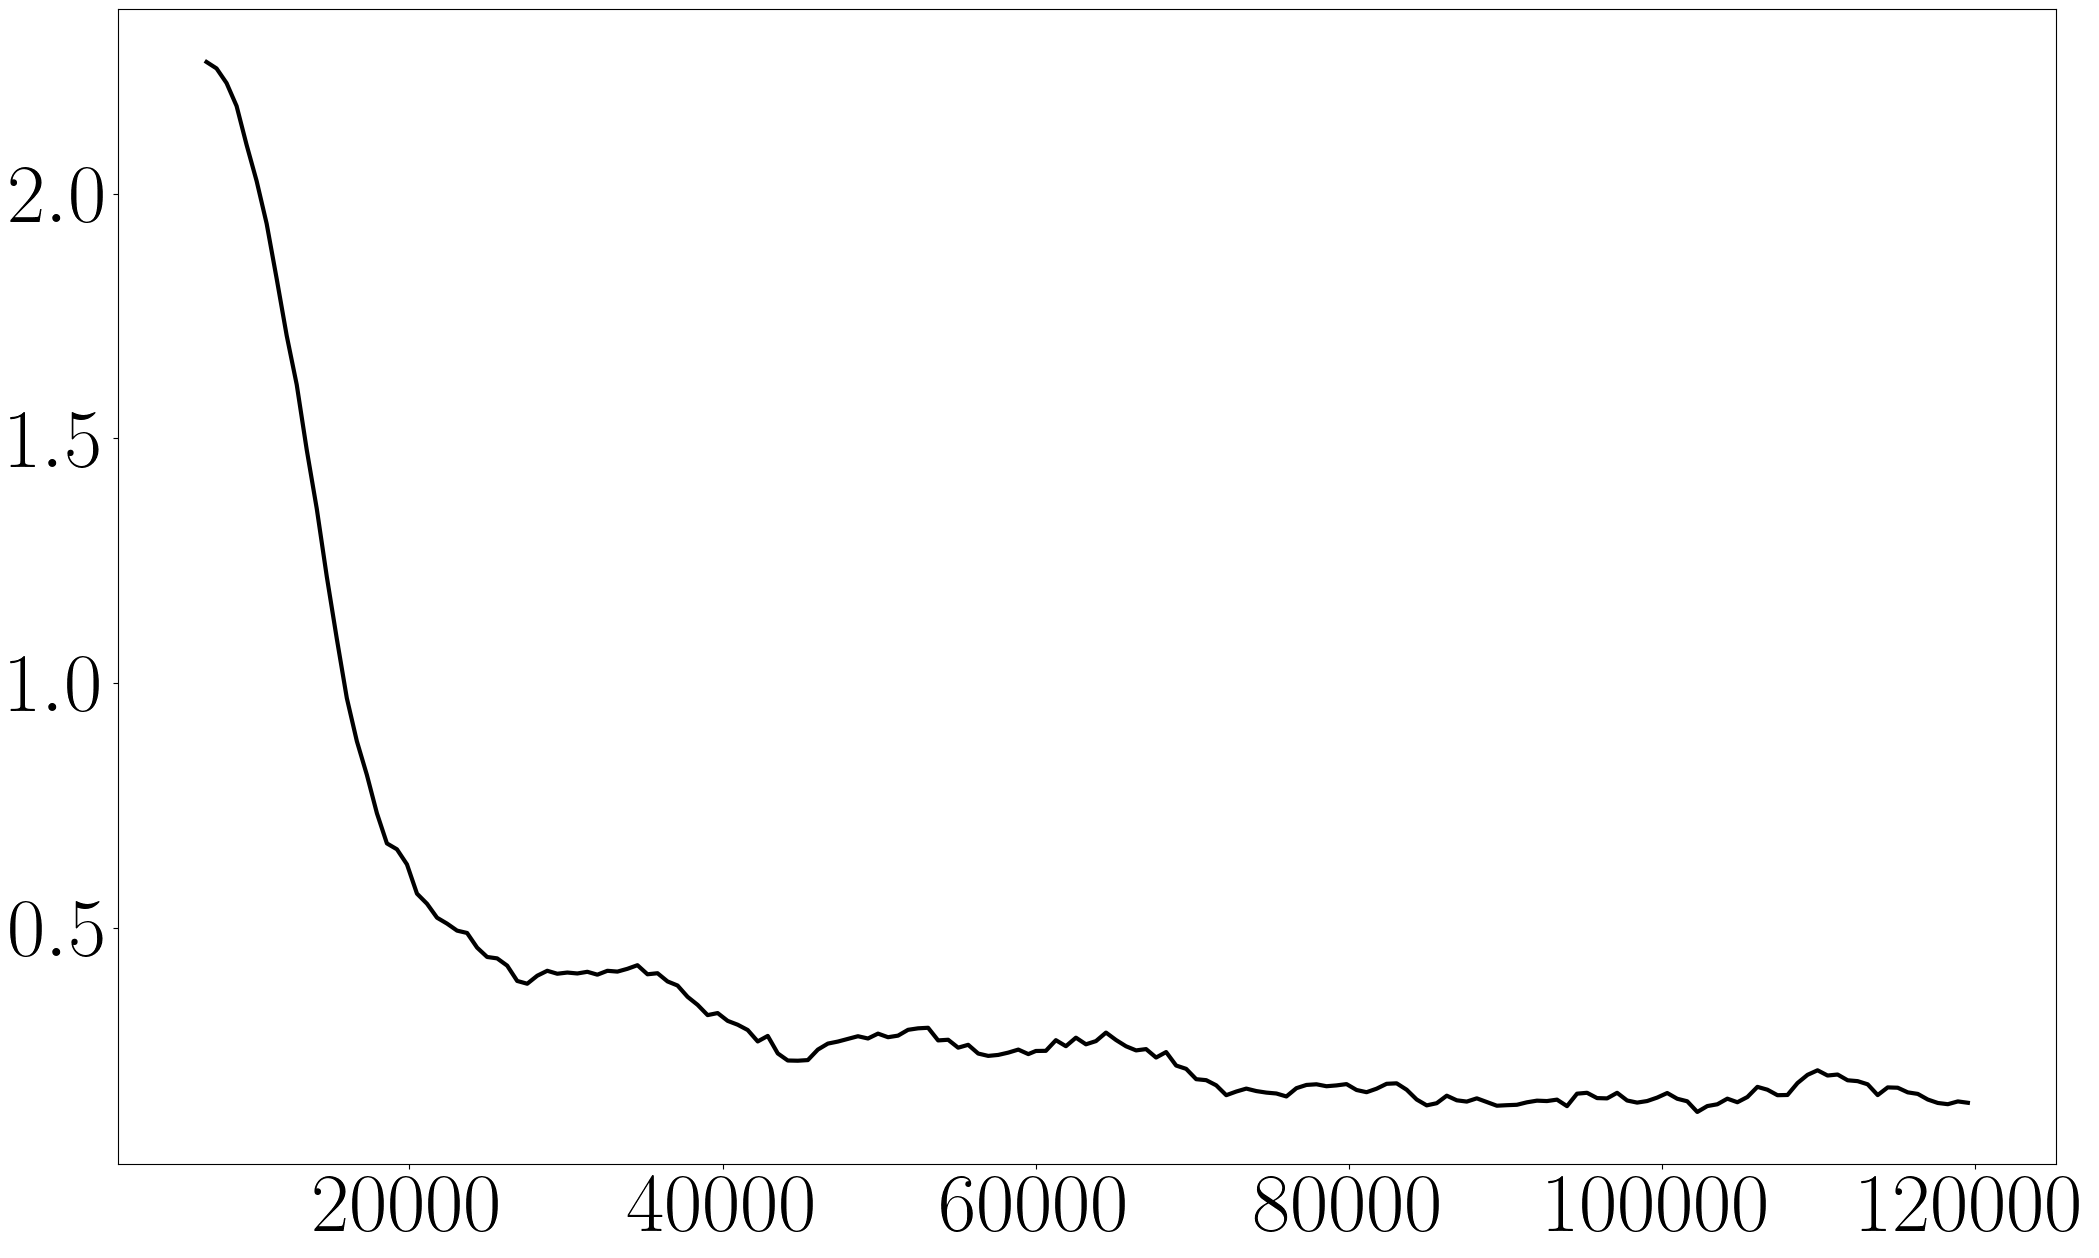

In [97]:
print('test')
test(testloader_mnist, network)
print('\ntrain')
test(trainloader_mnist, network)

df_train = pd.DataFrame()
df_train[name] = pd.read_csv(path+'traincurve_'+name+'.csv',index_col='counter')['losses']
#df_train['rollmean_'+name] = pd.rolling_mean(df_train[name], window=12)
df_train['rollmean_'+name] = df_train[name].rolling(window=window).mean()
plt.plot(df_train['rollmean_CNN'], color='black', label='CNN', linewidth=3)
plt.show()

# Quantum CNN - Training

##### Define set of values for key quantum parameters
- epsilon_RANGE = $\epsilon$
- Cap_RANGE = $T$
- ratio_RANGE = $\sigma$
- BackpErr_RANGE = $\delta$

In [98]:
epsilon_RANGE = [0.01, 0.1]
Cap_RANGE = [2, 10]
ratio_RANGE = [0.1,0.2,0.3,0.4,0.5]
BackpErr_RANGE = [0.01, 0.1]

##### A loop that define and train QCNN for each combination of parameters 

In [99]:
for BackpErr in BackpErr_RANGE:
    for Cap in Cap_RANGE: 
        for ratio in ratio_RANGE: 
            for epsilon in epsilon_RANGE:
                time0 = time.time()
                print('\n\n********** ratio:',ratio,'**********')
                print('********** BackpErr:',BackpErr,'**********')
                print('********** epsilon:',epsilon,'********')
                print('********** Cap:',Cap,'**************')
                
                            # 1 -  list to store important values
                    #layer 1
                M_list_1 = []
                Average_list_1 = []
                F_mu_list_1 = []
                A_mu_list_1 = []
                    #layer 2
                M_list_2 = []
                Average_list_2 = []
                F_mu_list_2 = []
                A_mu_list_2 = []

                
                
                            # 2 -  define the QCNN
                class QCNN(nn.Module):
                    def __init__(self):
                        super(QCNN, self).__init__()
                        self.conv1 = nn.Conv2d(1, 5, kernel_size=7)
                        self.conv2 = nn.Conv2d(5, 10, kernel_size=7)
                        self.fc1 = nn.Linear(2560, 300) 
                        self.fc2 = nn.Linear(300, 50)
                        self.fc3 = nn.Linear(50, 10)

                    def activation_function_CapReLu(self,input_tensor, Cap):
                        output_tensor = torch.clamp(input_tensor, min=0, max=Cap)
                        return output_tensor

                    def get_norm_matrix(self, input_tensor, conv): # conv should be self.conv1 for instance
                        """Calculate the norm of A_p and F_q, but also the mu(A) and mu(F)"""
                        kernel = conv.weight.data
                        h = kernel.shape[2]
                        w = kernel.shape[3]
                        H = input_tensor.shape[2]
                        W = input_tensor.shape[3]
                        # 0: prepare matrices
                        F = []
                        A = []
                        # 1: F_q norm calculations (kernel)
                        kernels_norms = []
                        for q in range(len(kernel)): #for each channels q
                            Fq = kernel[q]
                            kernels_norms.append(torch.norm(Fq).numpy())#add the norm of F_q to the list of norms
                            Fq = Fq.detach().numpy().flatten()
                            F.append(Fq) #add the column F_q to the matrix F
                        kernels_norms = np.array(kernels_norms)
                        F = np.array(F).transpose()
                        # 2: A_p norm calculations (input)
                        input_norms = []
                        for i in range(H-h+1):
                            for j in range(W-w+1): #for each 'kernel' subregion in the input
                                Ap = input_tensor[0,0,0+i:h+i,0+j:w+j] #selected subregion
                                norm_p = torch.norm(Ap)
                                input_norms.append(norm_p.detach().numpy().flatten()) #add the norm of A_p to the list of norms
                                Ap = Ap.detach().numpy().flatten() #transform as numpy vector
                                A.append(Ap) #add the row A_p to the matrix A
                        input_norms = np.array(input_norms)
                        A = np.array(A)
                        # 3: calculate mu=(Frob norm / Spectral norm)
                        F_mu = np.linalg.norm(F, 'fro')/np.linalg.norm(F, 2)
                        A_mu = np.linalg.norm(A, 'fro')/np.linalg.norm(A, 2)
                        # 4: calculate the matrix of ||Ap||*||Fq||
                        norm_matrix_output = np.outer(input_norms, kernels_norms) #we create the matrix of ||Ap||*||Fq||
                        return norm_matrix_output, F_mu, A_mu

                    def add_gaussian_noise(self, input_tensor, epsilon, norm_matrix): 
                        #norm_matrix is a matrix of ||Ap||*||Fq||
                        #the noise matrix is gaussian values centered on 0 and with std deviation of epsilon
                        #output = input +2*noise*||Ap||*||Fq||
                        noise = torch.Tensor(input_tensor.data.new(input_tensor.size()).normal_(0, epsilon))
                        norms_tensor = np.reshape(norm_matrix.transpose(), 
                                                  (1,input_tensor.shape[1],input_tensor.shape[2],input_tensor.shape[3]))
                        norms_tensor = torch.from_numpy(norms_tensor) #it was a numpy object
                        output_tensor = input_tensor + 2*torch.mul(noise, norms_tensor, out=None) #torch.mul : entrywise multiplication noise*||Ap||*||Fq||
                        output_tensor = torch.clamp(output_tensor, min=0, max=Cap) #no value should be less than 0 or more than Cap! 
                        return output_tensor    

                    def quantum_sampling(self, input_tensor, ratio):
                        output_tensor = torch.zeros_like(input_tensor)
                        num_samples = int(ratio*input_tensor[0].numel()) # ratio x number of elements in each tensor of the batch
                        for i in range(input_tensor.shape[0]): #for each tensor in the batch             
                            x = input_tensor[i] # tensor n°i
                            x_vec = x.flatten() # vectorize
                            probabilities = x_vec #quantum sampling
                            m = Categorical(probs=probabilities) # create the torch function to sample with probability distribution = x_vec
                            sample_index = m.sample((num_samples,)) #sample num_samples times
                            y = torch.zeros(x_vec.shape) # create zeros vector of same length
                            y[sample_index] = 1 # this is the mask
                            out = x_vec*y # apply mask
                            out = out.reshape(x.shape) # reshape to initial tensor
                            output_tensor[i] = out
                        return output_tensor

                    def calculate_average(self, input_tensor):
                        average = torch.mean(input_tensor)
                        return average.detach().numpy()

                    def forward(self, x):

                        #LAYER1
                        #1: stats and matrix values
                        norm_matrix_1, F_mu_1, A_mu_1= self.get_norm_matrix(x, self.conv1) # norm_matrix will be used in add_gaussian_noise later
                        M_list_1.append(np.max(norm_matrix_1)) # needed for stat: max of the norm_matrix
                        F_mu_list_1.append(F_mu_1)
                        A_mu_list_1.append(A_mu_1)
                                # #1.5: Plot
                                #plt.imshow(x[0,0,:,:].detach().numpy(),cmap='gray')
                                #plt.show()
                        #2:operations
                        x = self.conv1(x) #first convolution
                        x = self.activation_function_CapReLu(x,Cap) #caprelu
                        x = self.add_gaussian_noise(x,epsilon,norm_matrix_1) #a.e. noise (with multiplicative norms)
                        x = self.quantum_sampling(x, ratio) #quantum sampling
                        #3:stats
                        Average_list_1.append(self.calculate_average(x)) 

                        #LAYER2
                        norm_matrix_2, F_mu_2, A_mu_2 = self.get_norm_matrix(x, self.conv2) # will be used in add_gaussian_noise later
                        M_list_2.append(np.max(norm_matrix_2)) # needed for stat: max of the norm_matrix
                        F_mu_list_2.append(F_mu_2)
                        A_mu_list_2.append(A_mu_2)
                        x = self.conv2(x)
                        x = self.activation_function_CapReLu(x,Cap)
                        x = self.add_gaussian_noise(x,epsilon,norm_matrix_2)
                        x = self.quantum_sampling(x, ratio)
                        Average_list_2.append(self.calculate_average(x))

                        #Fully connected Layer
                        x = x.view(x.shape[0],-1)
                        x = F.relu(self.fc1(x))
                        x = F.relu(self.fc2(x))
                        x = F.log_softmax(self.fc3(x))

                        #save stats: M, mu(F), mu(A) and Average layer 
                        df_ = pd.DataFrame({'M_list_1': M_list_1,
                                            'Average_list_1': Average_list_1,
                                            'F_mu_list_1':F_mu_list_1,
                                            'A_mu_list_1':A_mu_list_1,
                                            'M_list_2': M_list_2,
                                            'Average_list_2': Average_list_2,
                                            'F_mu_list_2':F_mu_list_2,
                                            'A_mu_list_2':A_mu_list_2,})
                        df_.to_csv(path+'_values_'+name+'.csv')

                        return x
                    
                    
                    
                
                #name
                name = 'QCNN_ratio-'+str(ratio)+'_epsilon-'+str(epsilon)+'_Cap-'+str(Cap)+'_BackpErr_'+str(BackpErr)
                
                                # 3  -  Three possible cases to not train what was already trained
                #CASE 1 : do not run if the combinaison of parameters have already been done! 
                if os.path.isfile((path+name+'.pth')):
                    print("---->ALREADY COMPUTED<----")
                    print('# of logs:',len(pd.read_csv(path+'traincurve_'+name+'.csv',index_col='counter')['losses']),'\n')


                #CASE 2 : if the training was stopped in the middle, retrain from checkpoint
                elif os.path.isfile((path+'model_'+name+'.pth')):
                    print("----> RETRAIN FROM CHECKPOINT <----\n")              
                    continued_network = QCNN()
                    Quantum_optimizer = Quantum_SGD(continued_network.parameters(), lr=learning_rate, noise=BackpErr)
                    #load network state
                    network_state_dict = torch.load(path+'model_'+name+'.pth')
                    continued_network.load_state_dict(network_state_dict)
                    #load optimizer state
                    optimizer_state_dict = torch.load(path+'optimizer_'+name+'.pth')
                    Quantum_optimizer.load_state_dict(optimizer_state_dict)
                    #load traincurve info
                    df_traincurve = pd.read_csv(path+'traincurve_'+name+'.csv',index_col='counter')['losses']
                    train_losses = list(np.array(df_traincurve))
                    train_counter = list(np.array(df_traincurve.index))
                    #how many epochs need to be run? 
                    #in total must be 188 logs = np.ceil(n_epochs*60000/(batch_size_train*log_interval))
                    total_expected_logs = np.ceil(n_epochs*60000/(batch_size_train*log_interval))
                    number_current_logs = len(df_traincurve)
                    current_epoch = int((number_current_logs // (total_expected_logs/n_epochs)) + 1)
                    # ------ TRAIN from middle of the epoch------
                    for epoch in range(current_epoch, n_epochs + 1):
                        print("\nEpoch n°",epoch)
                        if epoch == current_epoch: #current epoch: start at the current log
                            print("Start from middle, at batch n°",number_current_logs*log_interval)
                            train_from_middle(epoch, trainloader_mnist, continued_network, name, path, Quantum_optimizer, number_current_logs)
                            print('\nTIME:',round((time.time()-time0)/60,2),'min')
                        if epoch > current_epoch: #next epochs: start from beggining
                            print("Start at the beginning")
                            train(epoch, trainloader_mnist, continued_network, name, path, Quantum_optimizer)
                            print('\nTIME:',round((time.time()-time0)/60,2),'min')
                    # Save the network - occurs only when it's all finished (important)
                    print('\nFINISH TRAINING',n_epochs,'EPOCHS')
                    torch.save(continued_network.state_dict(), path+name+'.pth')



                #CASE 3 :  if it's a new training!
                else:
                    print("---->NEW TRAINING<----\n")  
                    network = QCNN()
                    Quantum_optimizer = Quantum_SGD(network.parameters(), lr=learning_rate, noise=BackpErr)
                    train_losses = []
                    train_counter = []
                    #current epoch is the first one
                    current_epoch = 1
                    # ------ TRAIN from beggining------
                    for epoch in range(current_epoch, n_epochs + 1):
                        print("\nEpoch #",epoch)
                        train(epoch, trainloader_mnist, network, name, path, Quantum_optimizer) #only train
                        print('\nTIME:',round((time.time()-time0)/60,2),'min')
                    # Save the network - occurs only when it's all finished (important)
                    print('\nFINISH TRAINING',n_epochs,'EPOCHS')
                    torch.save(network.state_dict(), path+name+'.pth')

print('\n **DONE**')



********** ratio: 0.1 **********
********** BackpErr: 0.01 **********
********** epsilon: 0.01 ********
********** Cap: 2 **************
---->NEW TRAINING<----


Epoch # 1


/var/folders/4k/jv3kd27s2z5cnl1vjq1jvbqc0000gp/T/ipykernel_75384/3046839814.py:142: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.fc3(x))


Train Epoch: 1 [59520/60000 (99%)]	Loss: 2.264019
TIME: 2.2 min

Epoch # 2
Train Epoch: 2 [59520/60000 (99%)]	Loss: 1.078126
TIME: 4.6 min

FINISH TRAINING 2 EPOCHS


********** ratio: 0.1 **********
********** BackpErr: 0.01 **********
********** epsilon: 0.1 ********
********** Cap: 2 **************
---->NEW TRAINING<----


Epoch # 1
Train Epoch: 1 [59520/60000 (99%)]	Loss: 2.307423
TIME: 2.25 min

Epoch # 2
Train Epoch: 2 [59520/60000 (99%)]	Loss: 2.301941
TIME: 4.8 min

FINISH TRAINING 2 EPOCHS


********** ratio: 0.2 **********
********** BackpErr: 0.01 **********
********** epsilon: 0.01 ********
********** Cap: 2 **************
---->NEW TRAINING<----


Epoch # 1
Train Epoch: 1 [59520/60000 (99%)]	Loss: 0.752524
TIME: 2.26 min

Epoch # 2
Train Epoch: 2 [59520/60000 (99%)]	Loss: 0.402282
TIME: 4.7 min

FINISH TRAINING 2 EPOCHS


********** ratio: 0.2 **********
********** BackpErr: 0.01 **********
********** epsilon: 0.1 ********
********** Cap: 2 **************
---->NEW TRAINING<

KeyboardInterrupt: 

### Plot Learning curves

In [100]:
#define set of parameters we want for the plots
epsilon_RANGE = [0.01]
Cap_RANGE = [2]
ratio_RANGE = [0.5, 0.4, 0.3, 0.2,0.1]
BackpErr_RANGE = [0.1]

In [101]:
#load training data 

all_data = pd.DataFrame()

window = 12
name_list = []
i=0

for ratio in ratio_RANGE:
    for Cap in Cap_RANGE:
        for epsilon in epsilon_RANGE:
            for BackpErr in BackpErr_RANGE:
                name = 'QCNN_ratio-'+str(ratio)+'_epsilon-'+str(epsilon)+'_Cap-'+str(Cap)+'_BackpErr_'+str(BackpErr)
                if os.path.isfile((path+'traincurve_'+name+'.csv')): #the file is here = the combinaison has been tried
                    i+=1
                    name_list.append(name)
                    df_train = pd.DataFrame()
                    df_train[name] = pd.read_csv(path+'traincurve_'+name+'.csv',index_col='counter')['losses']
                    print(name, df_train[name].shape)
                    #df_train['rollmean_'+name] = pd.rolling_mean(df_train[name], window=window)
                    #df_train['rollstd_'+name] = pd.rolling_std(df_train[name], window=window)
                    df_train['rollmean_'+name] = df_train[name].rolling(window=window).mean()
                    df_train['rollstd_'+name] = df_train[name].rolling(window=window).std()                    
                    all_data = pd.concat([all_data, df_train], axis=1)
                
# Compare to classical CNN
df_train = pd.DataFrame()
name = 'CNN'
df_train[name] = pd.read_csv(path+'traincurve_'+name+'.csv',index_col='counter')['losses']
#df_train['rollmean_'+name] = pd.rolling_mean(df_train[name], window=window)
#df_train['rollstd_'+name] = pd.rolling_std(df_train[name], window=window)
df_train['rollmean_'+name] = df_train[name].rolling(window=window).mean()
df_train['rollstd_'+name] = df_train[name].rolling(window=window).std()
all_data = pd.concat([all_data, df_train], axis=1) 

print("\n----",i,'EXPERIMENTS ----')

QCNN_ratio-0.3_epsilon-0.01_Cap-2_BackpErr_0.1 (188,)
QCNN_ratio-0.2_epsilon-0.01_Cap-2_BackpErr_0.1 (188,)
QCNN_ratio-0.1_epsilon-0.01_Cap-2_BackpErr_0.1 (188,)

---- 3 EXPERIMENTS ----


/var/folders/4k/jv3kd27s2z5cnl1vjq1jvbqc0000gp/T/ipykernel_75384/2168479940.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color = plt.cm.get_cmap('hsv', 30)


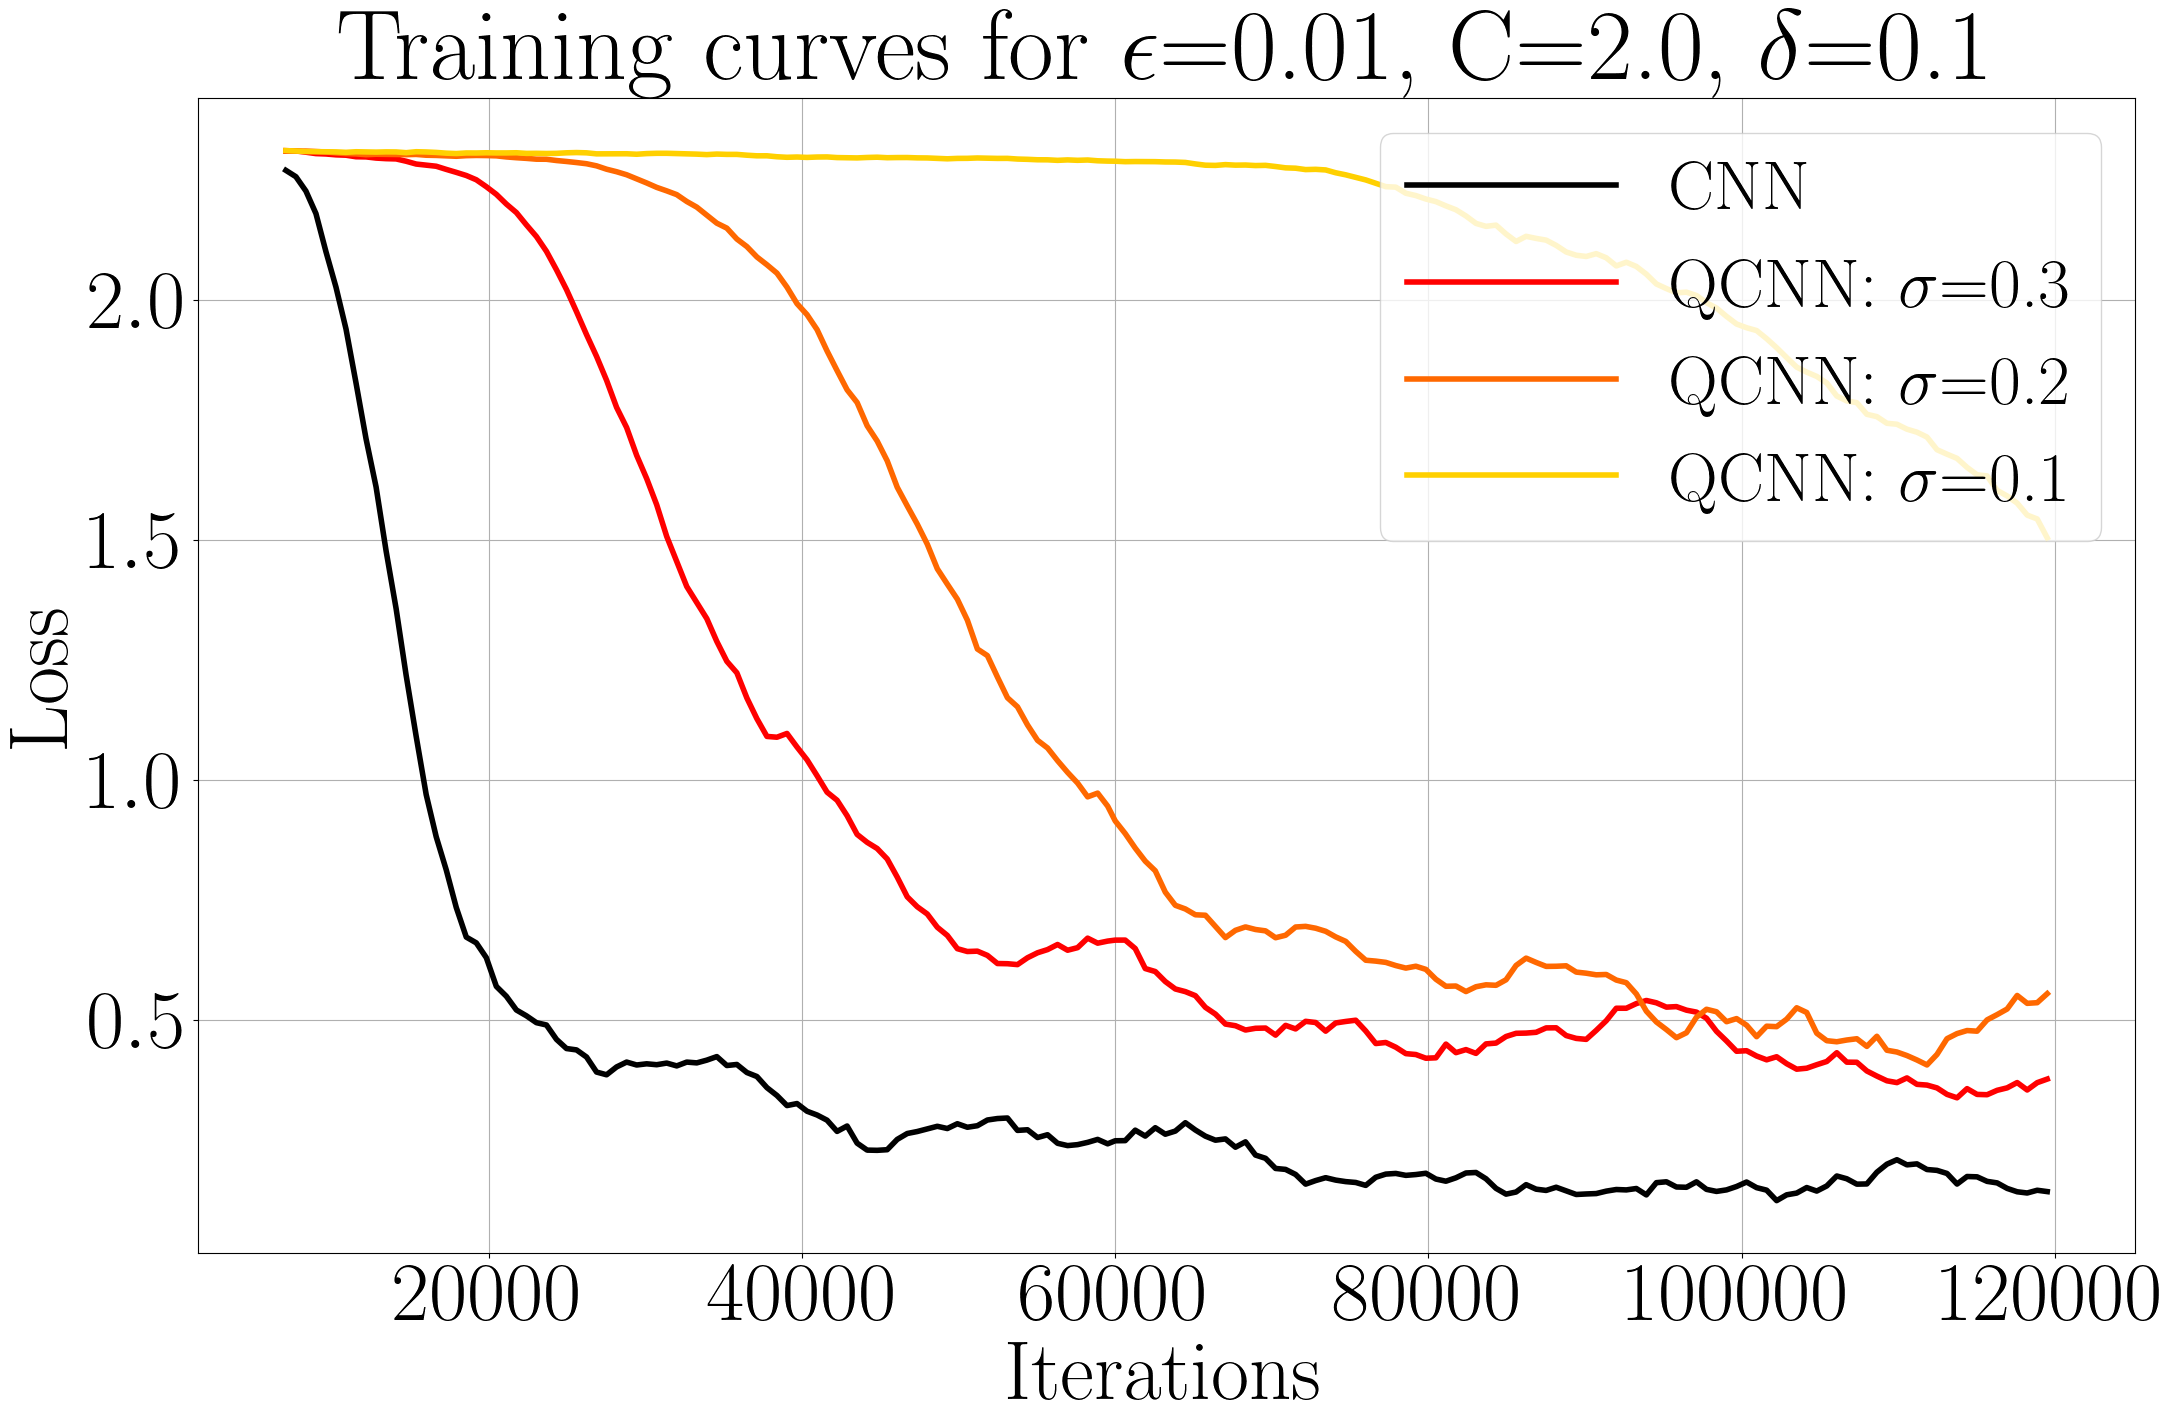

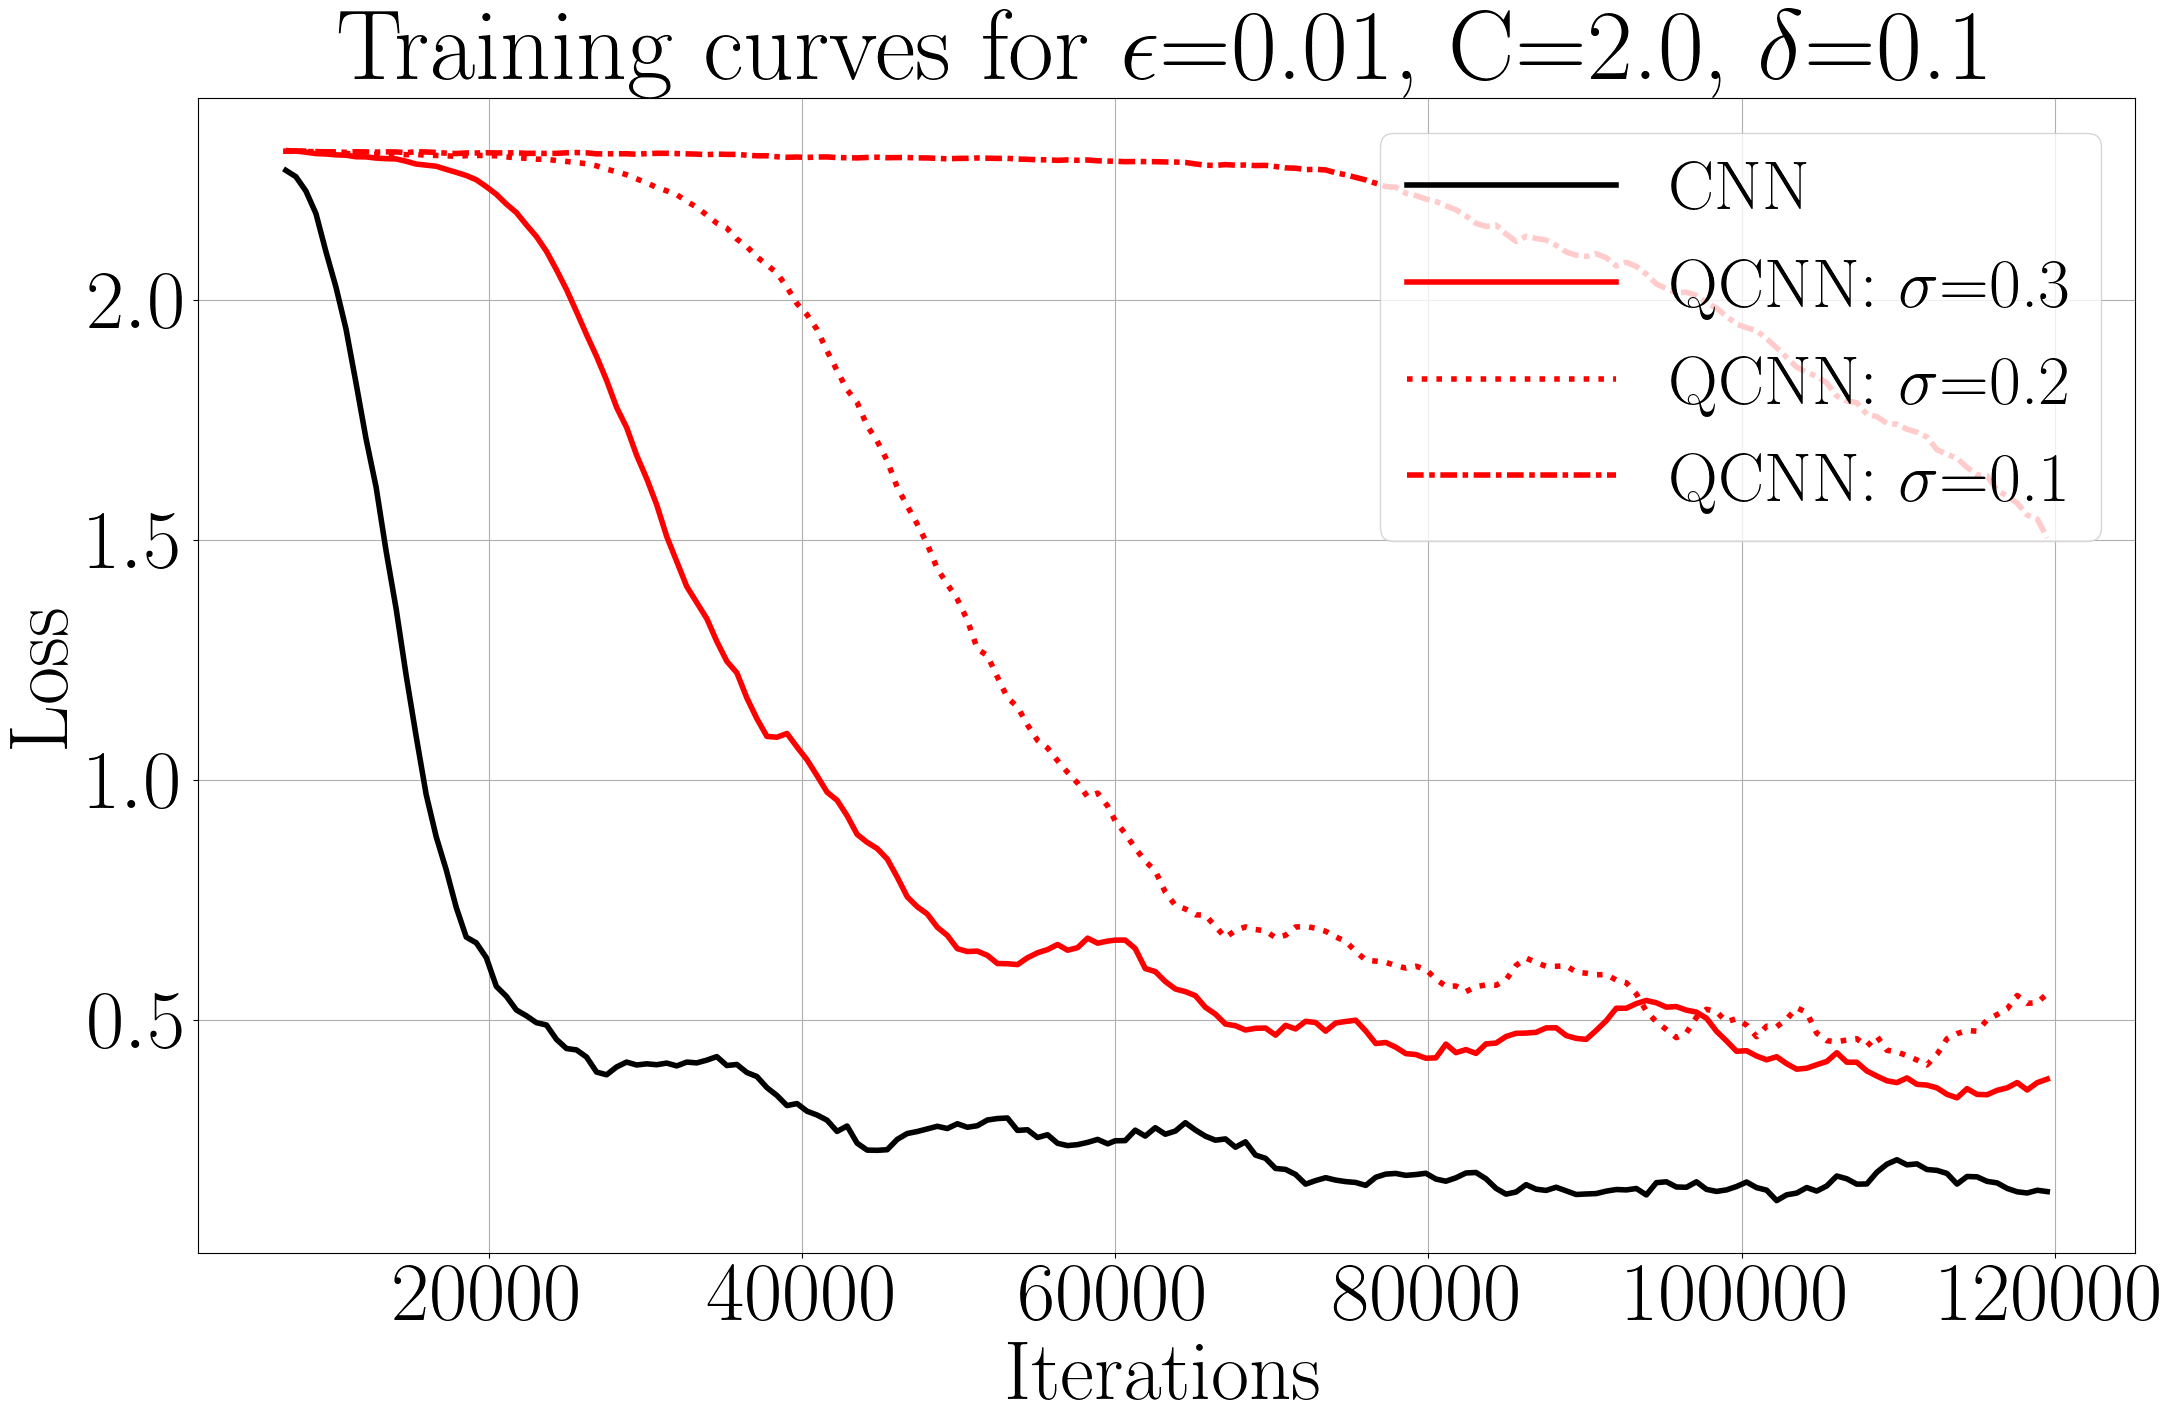

In [102]:
#plot with color

plt.figure(figsize=(25, 15))

plt.plot(all_data['rollmean_CNN'], color='black', label='CNN', linewidth=4)    
for count, name in enumerate(name_list):
    label_split=name.split('_')
    ratio = float((label_split[1].split('-'))[1])
    epsilon = float((label_split[2].split('-'))[1])
    cap = float((label_split[3].split('-'))[1])
    BackprErr = float((label_split[5]))
    label = label_split[0]+': $\sigma$='+str(ratio)#+', $\epsilon$='+str(epsilon)+', cap='+str(cap)+', BackprErr='+str(BackprErr)
    
    color = plt.cm.get_cmap('hsv', 30)
    plt.plot(all_data['rollmean_'+name], color=color(2*count), label=label, linewidth=4)
    
    plt.legend(loc='upper right')
    plt.title('Training curves for $\epsilon$={}, C={}, $\delta$={}'.format(epsilon,cap,BackprErr))
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.grid()
    

fname = 'training_epsilon{}_T{}_delta{}'.format(epsilon,int(cap),BackprErr)
plt.savefig('./images/'+fname.replace('.','')+'.png')
plt.show(block=False)



#plot without color  

plt.figure(figsize=(25, 15))

plt.plot(all_data['rollmean_CNN'], color='black', label='CNN', linewidth=4)
for count, name in enumerate(name_list):
    label_split=name.split('_')
    ratio = float((label_split[1].split('-'))[1])
    epsilon = float((label_split[2].split('-'))[1])
    cap = float((label_split[3].split('-'))[1])
    BackprErr = float((label_split[5]))
    label = label_split[0]+': $\sigma$='+str(ratio)#+', $\epsilon$='+str(epsilon)+', cap='+str(cap)+', BackprErr='+str(BackprErr)
    
    LINESTYLE = ["-",":",(0, (3, 1, 1, 1)),"--",'-.']
    plt.plot(all_data['rollmean_'+name], color='red', label=label, linewidth=4, linestyle=LINESTYLE[count%len(LINESTYLE)]) #color=color(count)
    
    plt.legend(loc='upper right')
    plt.title('Training curves for $\epsilon$={}, C={}, $\delta$={}'.format(epsilon,cap,BackprErr))
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.grid()
  
    
fname = 'training_epsilon{}_T{}_delta{}_unicolor'.format(epsilon,int(cap),BackprErr)
plt.savefig('./images/'+fname.replace('.','')+'.png')
plt.show(block=False)

    

## Test set loss & accuracy

In [103]:
BackpErr_RANGE = [0.01, 0.1]
epsilon_RANGE = [0.01, 0.1]
Cap_RANGE = [10,2]
ratio_RANGE = [0.5]#, 0.4, 0.3, 0.2, 0.1]

##### quantumly trained QCNN - testset loss & accuracy

In [104]:
#%%capture cap --no-stderr #USE TO SAVE prints as text files!

result = []

# path = './full_qcnn_2/'

for ratio in ratio_RANGE:
    for Cap in Cap_RANGE:
        for epsilon in epsilon_RANGE:
            for BackpErr in BackpErr_RANGE:

                name = 'QCNN_ratio-'+str(ratio)+'_epsilon-'+str(epsilon)+'_Cap-'+str(Cap)+'_BackpErr_'+str(BackpErr)
                if os.path.isfile((path+'model_'+name+'.pth')):

                    
                    class QCNN(nn.Module):
                        def __init__(self):
                            super(QCNN, self).__init__()
                            self.conv1 = nn.Conv2d(1, 5, kernel_size=7)
                            self.conv2 = nn.Conv2d(5, 10, kernel_size=7)
                            self.fc1 = nn.Linear(2560, 300) 
                            self.fc2 = nn.Linear(300, 50)
                            self.fc3 = nn.Linear(50, 10)

                        def activation_function_CapReLu(self,input_tensor, Cap):
                            output_tensor = torch.clamp(input_tensor, min=0, max=Cap)
                            return output_tensor

                        def get_norm_matrix(self, input_tensor, conv): # conv should be self.conv1 for instance
                            """Calculate the norm of A_p and F_q, but also the mu(A) and mu(F)"""
                            kernel = conv.weight.data
                            h = kernel.shape[2]
                            w = kernel.shape[3]
                            H = input_tensor.shape[2]
                            W = input_tensor.shape[3]
                            # 0: prepare matrices
                            F = []
                            A = []
                            # 1: F_q norm calculations (kernel)
                            kernels_norms = []
                            for q in range(len(kernel)): #for each channels q
                                Fq = kernel[q]
                                kernels_norms.append(torch.norm(Fq).numpy())#add the norm of F_q to the list of norms
                                Fq = Fq.detach().numpy().flatten()
                                F.append(Fq) #add the column F_q to the matrix F
                            kernels_norms = np.array(kernels_norms)
                            F = np.array(F).transpose()
                            # 2: A_p norm calculations (input)
                            input_norms = []
                            for i in range(H-h+1):
                                for j in range(W-w+1): #for each 'kernel' subregion in the input
                                    Ap = input_tensor[0,0,0+i:h+i,0+j:w+j] #selected subregion
                                    norm_p = torch.norm(Ap)
                                    input_norms.append(norm_p.detach().numpy().flatten()) #add the norm of A_p to the list of norms
                                    Ap = Ap.detach().numpy().flatten() #transform as numpy vector
                                    A.append(Ap) #add the row A_p to the matrix A
                            input_norms = np.array(input_norms)
                            A = np.array(A)
                            # 3: calculate mu=(Frob norm / Spectral norm)
                            F_mu = np.linalg.norm(F, 'fro')/np.linalg.norm(F, 2)
                            A_mu = np.linalg.norm(A, 'fro')/np.linalg.norm(A, 2)
                            # 4: calculate the matrix of ||Ap||*||Fq||
                            norm_matrix_output = np.outer(input_norms, kernels_norms) #we create the matrix of ||Ap||*||Fq||
                            return norm_matrix_output, F_mu, A_mu

                        def add_gaussian_noise(self, input_tensor, epsilon, norm_matrix): 
                            #norm_matrix is a matrix of ||Ap||*||Fq||
                            #the noise matrix is gaussian values centered on 0 and with std deviation of epsilon
                            #output = input +2*noise*||Ap||*||Fq||
                            noise = torch.Tensor(input_tensor.data.new(input_tensor.size()).normal_(0, epsilon))
                            norms_tensor = np.reshape(norm_matrix.transpose(), 
                                                      (1,input_tensor.shape[1],input_tensor.shape[2],input_tensor.shape[3]))
                            norms_tensor = torch.from_numpy(norms_tensor) #it was a numpy object
                            output_tensor = input_tensor + 2*torch.mul(noise, norms_tensor, out=None) #torch.mul : entrywise multiplication noise*||Ap||*||Fq||
                            output_tensor = torch.clamp(output_tensor, min=0, max=Cap) #no value should be less than 0 or more than Cap! 
                            return output_tensor    

                        def quantum_sampling(self, input_tensor, ratio):
                            output_tensor = torch.zeros_like(input_tensor)
                            num_samples = int(ratio*input_tensor[0].numel()) # ratio x number of elements in each tensor of the batch
                            for i in range(input_tensor.shape[0]): #for each tensor in the batch             
                                x = input_tensor[i] # tensor n°i
                                x_vec = x.flatten() # vectorize
                                probabilities = x_vec #quantum sampling
                                m = Categorical(probs=probabilities) # create the torch function to sample with probability distribution = x_vec
                                sample_index = m.sample((num_samples,)) #sample num_samples times
                                y = torch.zeros(x_vec.shape) # create zeros vector of same length
                                y[sample_index] = 1 # this is the mask
                                out = x_vec*y # apply mask
                                out = out.reshape(x.shape) # reshape to initial tensor
                                output_tensor[i] = out
                            return output_tensor

                        def calculate_average(self, input_tensor):
                            average = torch.mean(input_tensor)
                            return average.detach().numpy()

                        def forward(self, x):

                            #LAYER1
                            #1: stats and matrix values
                            norm_matrix_1, F_mu_1, A_mu_1= self.get_norm_matrix(x, self.conv1) # norm_matrix will be used in add_gaussian_noise later
                            #2:operations
                            x = self.conv1(x) #first convolution
                            x = self.activation_function_CapReLu(x,Cap) #caprelu
                            x = self.add_gaussian_noise(x,epsilon,norm_matrix_1) #a.e. noise (with multiplicative norms)
                            x = self.quantum_sampling(x, ratio) #quantum sampling
                            #3:stats

                            #LAYER2
                            norm_matrix_2, F_mu_2, A_mu_2 = self.get_norm_matrix(x, self.conv2) # will be used in add_gaussian_noise later
                            x = self.conv2(x)
                            x = self.activation_function_CapReLu(x,Cap)
                            x = self.add_gaussian_noise(x,epsilon,norm_matrix_2)
                            x = self.quantum_sampling(x, ratio)

                            #Fully connected Layer
                            x = x.view(x.shape[0],-1)
                            x = F.relu(self.fc1(x))
                            x = F.relu(self.fc2(x))
                            x = F.log_softmax(self.fc3(x))

                            return x                    


                    net = QCNN()
                    #load network state
                    network_state_dict = torch.load(path+'model_'+name+'.pth') ##### HERE WE CHOOSE Q-CNN
                    net.load_state_dict(network_state_dict)

                    print('\n\t ***** network:', name,'*****')

                    test(testloader_mnist, net)
                    
                    ## No trainset it would be too long....


	 ***** network: QCNN_ratio-0.5_epsilon-0.01_Cap-10_BackpErr_0.01 *****


/var/folders/4k/jv3kd27s2z5cnl1vjq1jvbqc0000gp/T/ipykernel_75384/1531051276.py:121: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.fc3(x))
/usr/local/anaconda3/envs/myCondaVenv/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


batch n° 9 / 10 ...
Test set: Avg. loss: 0.1523, Accuracy: 9518/10000 (95.18%)

	 ***** network: QCNN_ratio-0.5_epsilon-0.1_Cap-10_BackpErr_0.01 *****
batch n° 9 / 10 ...
Test set: Avg. loss: 0.2546, Accuracy: 9168/10000 (91.68%)

	 ***** network: QCNN_ratio-0.5_epsilon-0.01_Cap-2_BackpErr_0.01 *****
batch n° 9 / 10 ...
Test set: Avg. loss: 0.2435, Accuracy: 9263/10000 (92.63%)

	 ***** network: QCNN_ratio-0.5_epsilon-0.1_Cap-2_BackpErr_0.01 *****
batch n° 9 / 10 ...
Test set: Avg. loss: 0.6254, Accuracy: 7950/10000 (79.50%)


##### classically trained QCNN - testset loss & accuracy

In [105]:
BackpErr_RANGE = [0.1]
epsilon_RANGE = [0.01, 0.1]
Cap_RANGE = [10]
ratio_RANGE = [0.5]#, 0.4, 0.3, 0.2, 0.1]

In [107]:
result = []

# path = './full_qcnn_2/'

for ratio in ratio_RANGE:
    for Cap in Cap_RANGE:
        for epsilon in epsilon_RANGE:
            for BackpErr in BackpErr_RANGE:

                name = 'QCNN_ratio-'+str(ratio)+'_epsilon-'+str(epsilon)+'_Cap-'+str(Cap)+'_BackpErr_'+str(BackpErr)
                if os.path.isfile((path+'model_'+name+'.pth')):

                    
                    class QCNN(nn.Module):
                        def __init__(self):
                            super(QCNN, self).__init__()
                            self.conv1 = nn.Conv2d(1, 5, kernel_size=7)
                            self.conv2 = nn.Conv2d(5, 10, kernel_size=7)
                            self.fc1 = nn.Linear(2560, 300) 
                            self.fc2 = nn.Linear(300, 50)
                            self.fc3 = nn.Linear(50, 10)

                        def activation_function_CapReLu(self,input_tensor, Cap):
                            output_tensor = torch.clamp(input_tensor, min=0, max=Cap)
                            return output_tensor

                        def get_norm_matrix(self, input_tensor, conv): # conv should be self.conv1 for instance
                            """Calculate the norm of A_p and F_q, but also the mu(A) and mu(F)"""
                            kernel = conv.weight.data
                            h = kernel.shape[2]
                            w = kernel.shape[3]
                            H = input_tensor.shape[2]
                            W = input_tensor.shape[3]
                            # 0: prepare matrices
                            F = []
                            A = []
                            # 1: F_q norm calculations (kernel)
                            kernels_norms = []
                            for q in range(len(kernel)): #for each channels q
                                Fq = kernel[q]
                                kernels_norms.append(torch.norm(Fq).numpy())#add the norm of F_q to the list of norms
                                Fq = Fq.detach().numpy().flatten()
                                F.append(Fq) #add the column F_q to the matrix F
                            kernels_norms = np.array(kernels_norms)
                            F = np.array(F).transpose()
                            # 2: A_p norm calculations (input)
                            input_norms = []
                            for i in range(H-h+1):
                                for j in range(W-w+1): #for each 'kernel' subregion in the input
                                    Ap = input_tensor[0,0,0+i:h+i,0+j:w+j] #selected subregion
                                    norm_p = torch.norm(Ap)
                                    input_norms.append(norm_p.detach().numpy().flatten()) #add the norm of A_p to the list of norms
                                    Ap = Ap.detach().numpy().flatten() #transform as numpy vector
                                    A.append(Ap) #add the row A_p to the matrix A
                            input_norms = np.array(input_norms)
                            A = np.array(A)
                            # 3: calculate mu=(Frob norm / Spectral norm)
                            F_mu = np.linalg.norm(F, 'fro')/np.linalg.norm(F, 2)
                            A_mu = np.linalg.norm(A, 'fro')/np.linalg.norm(A, 2)
                            # 4: calculate the matrix of ||Ap||*||Fq||
                            norm_matrix_output = np.outer(input_norms, kernels_norms) #we create the matrix of ||Ap||*||Fq||
                            return norm_matrix_output, F_mu, A_mu

                        def add_gaussian_noise(self, input_tensor, epsilon, norm_matrix): 
                            #norm_matrix is a matrix of ||Ap||*||Fq||
                            #the noise matrix is gaussian values centered on 0 and with std deviation of epsilon
                            #output = input +2*noise*||Ap||*||Fq||
                            noise = torch.Tensor(input_tensor.data.new(input_tensor.size()).normal_(0, epsilon))
                            norms_tensor = np.reshape(norm_matrix.transpose(), 
                                                      (1,input_tensor.shape[1],input_tensor.shape[2],input_tensor.shape[3]))
                            norms_tensor = torch.from_numpy(norms_tensor) #it was a numpy object
                            output_tensor = input_tensor + 2*torch.mul(noise, norms_tensor, out=None) #torch.mul : entrywise multiplication noise*||Ap||*||Fq||
                            output_tensor = torch.clamp(output_tensor, min=0, max=Cap) #no value should be less than 0 or more than Cap! 
                            return output_tensor    

                        def quantum_sampling(self, input_tensor, ratio):
                            output_tensor = torch.zeros_like(input_tensor)
                            num_samples = int(ratio*input_tensor[0].numel()) # ratio x number of elements in each tensor of the batch
                            for i in range(input_tensor.shape[0]): #for each tensor in the batch             
                                x = input_tensor[i] # tensor n°i
                                x_vec = x.flatten() # vectorize
                                probabilities = x_vec #quantum sampling
                                m = Categorical(probs=probabilities) # create the torch function to sample with probability distribution = x_vec
                                sample_index = m.sample((num_samples,)) #sample num_samples times
                                y = torch.zeros(x_vec.shape) # create zeros vector of same length
                                y[sample_index] = 1 # this is the mask
                                out = x_vec*y # apply mask
                                out = out.reshape(x.shape) # reshape to initial tensor
                                output_tensor[i] = out
                            return output_tensor

                        def calculate_average(self, input_tensor):
                            average = torch.mean(input_tensor)
                            return average.detach().numpy()

                        def forward(self, x):

                            #LAYER1
                            #1: stats and matrix values
                            norm_matrix_1, F_mu_1, A_mu_1= self.get_norm_matrix(x, self.conv1) # norm_matrix will be used in add_gaussian_noise later
                            #2:operations
                            x = self.conv1(x) #first convolution
                            x = self.activation_function_CapReLu(x,Cap) #caprelu
                            x = self.add_gaussian_noise(x,epsilon,norm_matrix_1) #a.e. noise (with multiplicative norms)
                            x = self.quantum_sampling(x, ratio) #quantum sampling
                            #3:stats

                            #LAYER2
                            norm_matrix_2, F_mu_2, A_mu_2 = self.get_norm_matrix(x, self.conv2) # will be used in add_gaussian_noise later
                            x = self.conv2(x)
                            x = self.activation_function_CapReLu(x,Cap)
                            x = self.add_gaussian_noise(x,epsilon,norm_matrix_2)
                            x = self.quantum_sampling(x, ratio)

                            #Fully connected Layer
                            x = x.view(x.shape[0],-1)
                            x = F.relu(self.fc1(x))
                            x = F.relu(self.fc2(x))
                            x = F.log_softmax(self.fc3(x))

                            return x                    


                    net = QCNN()
                    #load network state
                    network_state_dict = torch.load(path+'model_CNN.pth') ##### HERE WE CHOOSE CNN
                    net.load_state_dict(network_state_dict)

                    print('\n\t ***** network:', name,'*****')

                    test(testloader_mnist, net)
                    
                    ## No trainset it would be too long....